<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/03-modelagem_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo

## Biblitecas

Bibliotecas utilizadas para o processo

In [233]:
%pip install openai -q -U

In [234]:
import os
import math
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

from warnings import filterwarnings
filterwarnings('ignore')

In [235]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  azure_client = openai.AzureOpenAI(
      azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
      api_version=userdata.get('OPENAI_API_VERSION'),
      api_key=userdata.get('AZURE_OPENAI_API_KEY'),
  )

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento de dados e ajuste de dados/valores

In [236]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [237]:
df_time = df.to_pandas()
df_time['target'].value_counts()

,count
target,
No,8901631
Yes,13332


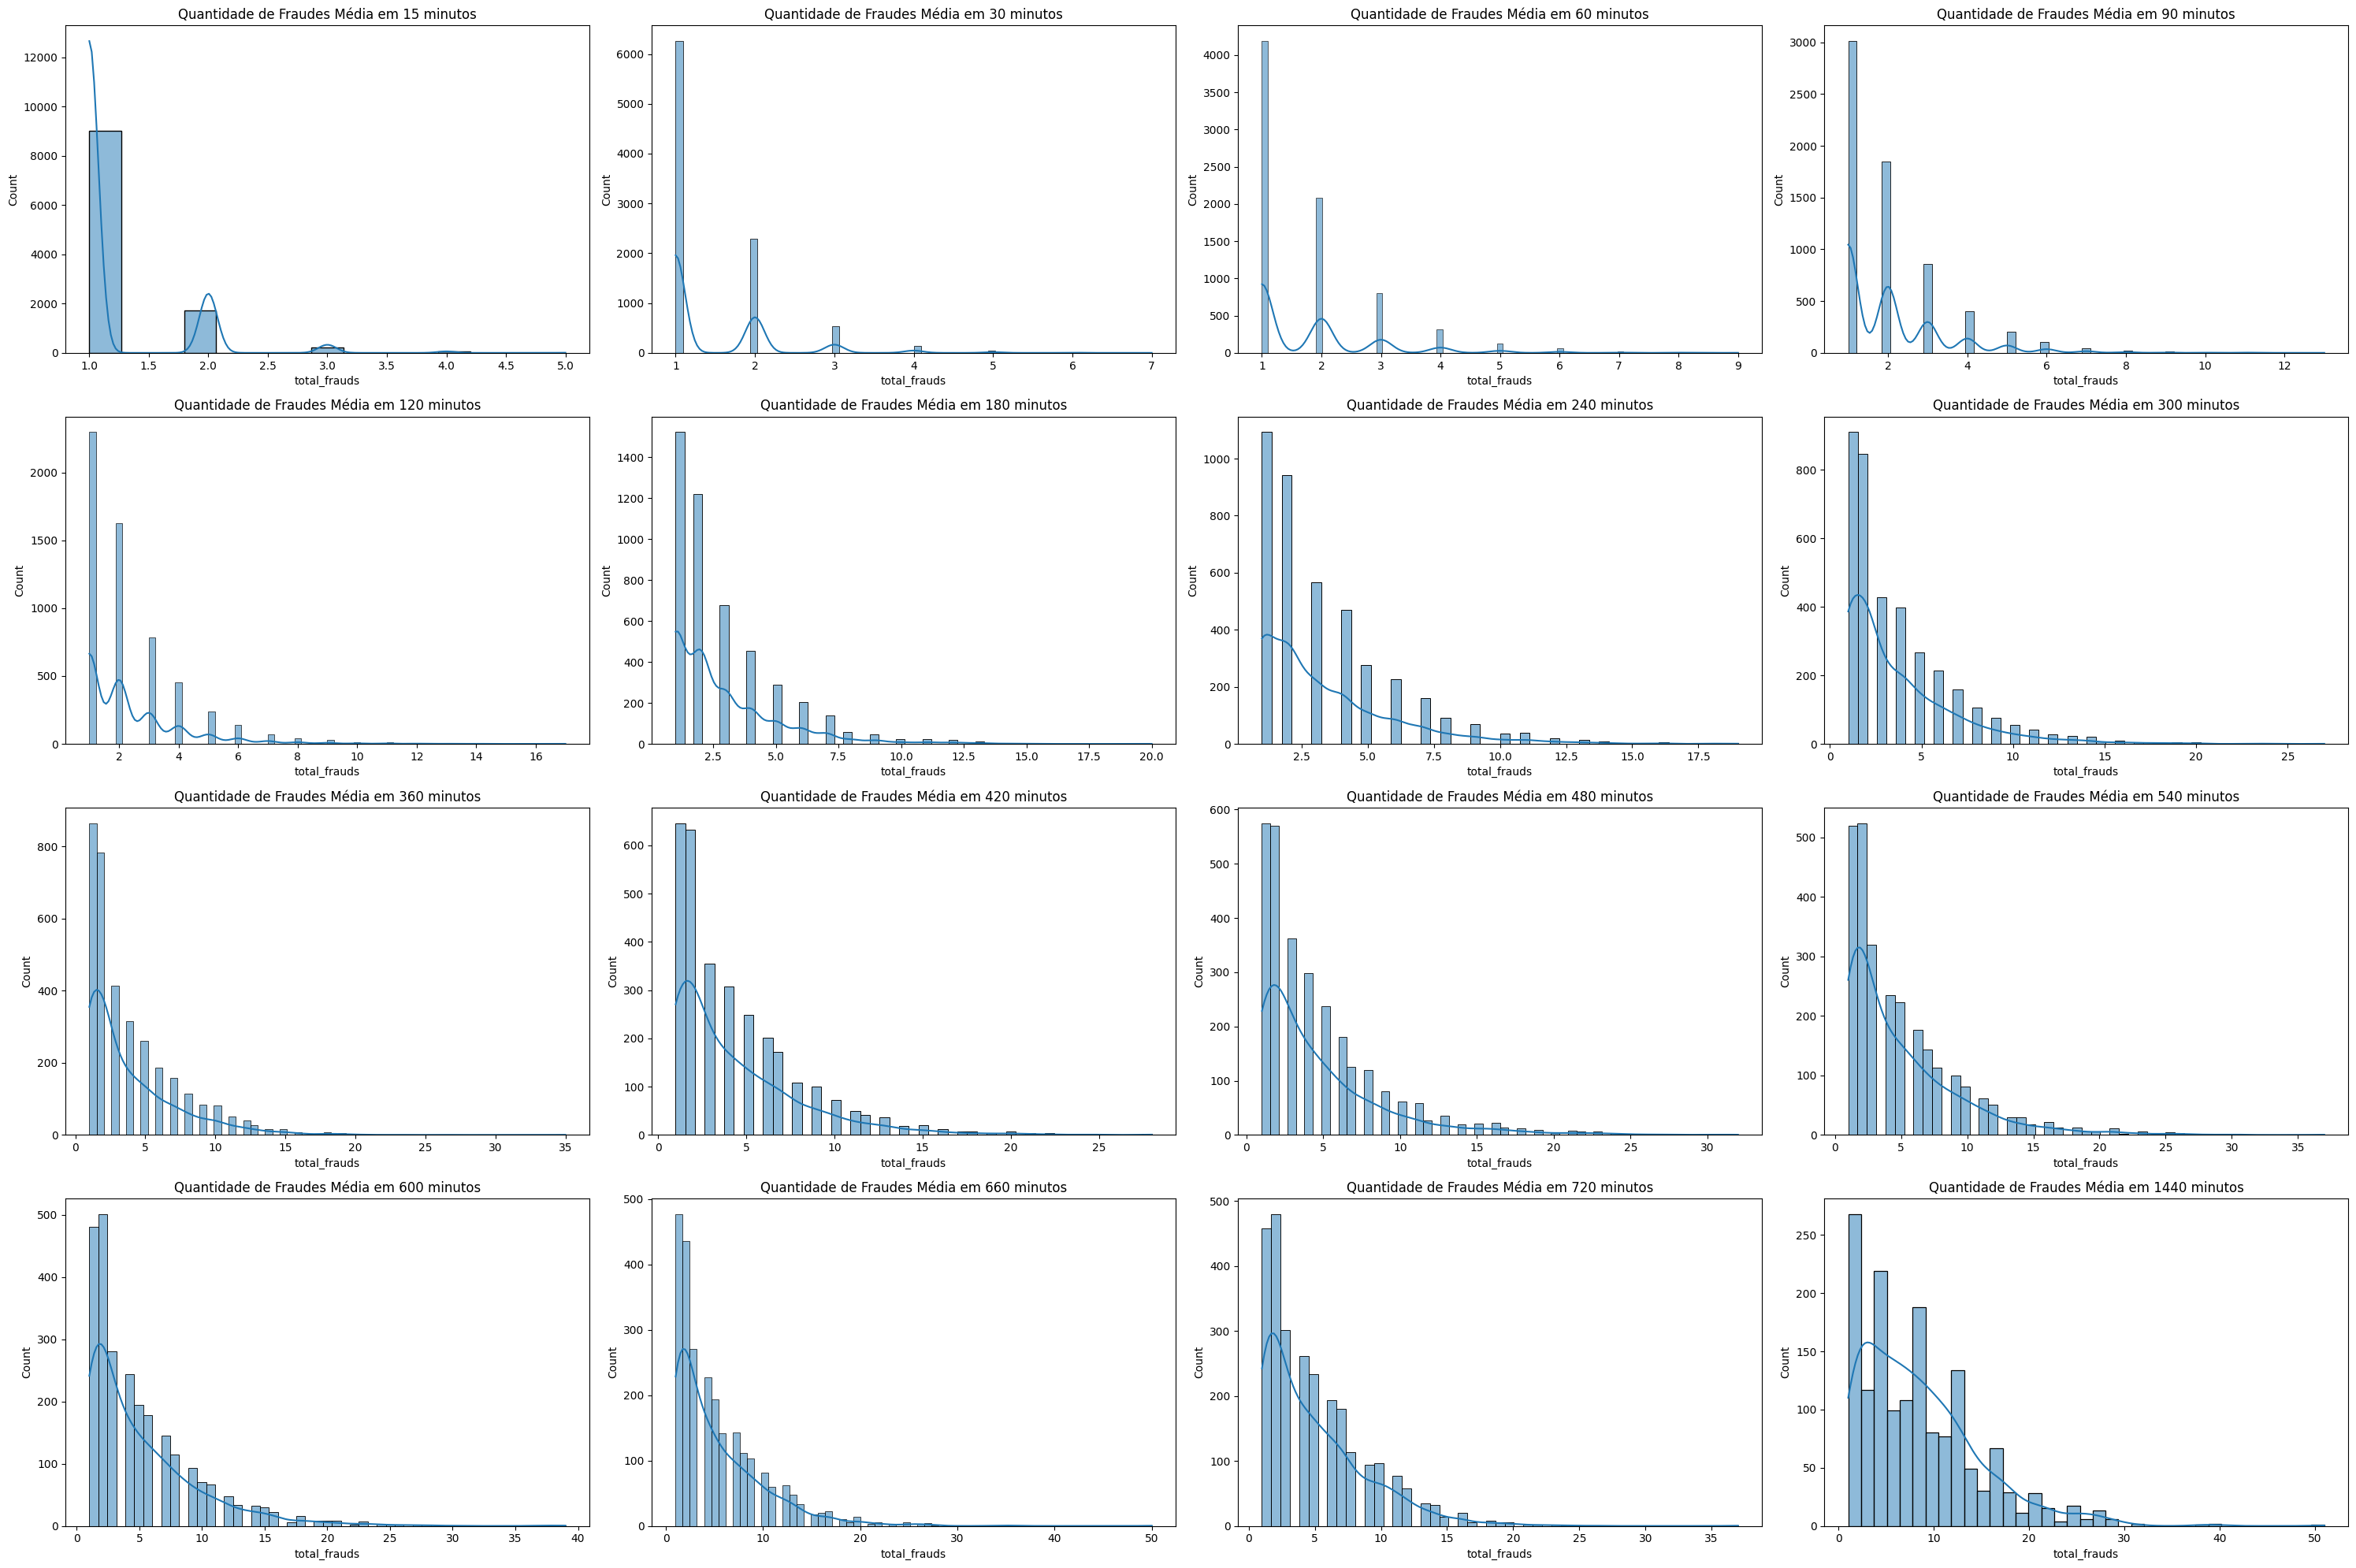

In [238]:
minutes = [15, 30, 60, 90, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target'].apply(lambda x: 1 if x == 'Yes' else 0)

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

In [239]:
df = df.filter(pl.col('amount') >= pl.lit(0))

In [240]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,card_has_chip
i64,datetime[ns],i64,i64,f64,str,i64,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,i64,f64,str,i64,str,str,str,str,str
17105507,2015-12-17 19:39:00,1140,2845,9.72,"""Swipe Transaction""",55060,66049.0,"""5812""",null,"""Eating Places and Restaurants""","""No""",44,65,1975,7,"""Male""","""591 South Avenue""",38.96,-95.25,27149.0,55351.0,152645.0,703,6,"""Mastercard""","""Debit""",5152235839088172,"""07/2023""",469,2,27298.0,"""05/2003""",2007,"""No""","""No""","""Lawrence""","""United States""","""No"""
17342279,2016-02-06 11:15:00,447,4617,147.97,"""Chip Transaction""",54773,49445.0,"""5311""",null,"""Department Stores""","""No""",79,68,1940,3,"""Male""","""5336 Tenth Drive""",43.22,-86.25,19131.0,30977.0,21507.0,796,5,"""Visa""","""Credit""",4659755318123494,"""01/2024""",764,2,9000.0,"""09/2006""",2008,"""No""","""No""","""Muskegon""","""United States""","""Yes"""
23043576,2019-06-01 22:06:00,1603,2381,22.33,"""Chip Transaction""",59397,83252.0,"""5812""",null,"""Eating Places and Restaurants""","""No""",41,65,1978,12,"""Male""","""6515 Hillside Drive""",44.65,-114.15,19036.0,38812.0,16331.0,762,4,"""Mastercard""","""Credit""",5903180777410762,"""02/2020""",618,1,14000.0,"""03/2019""",2019,"""No""","""No""","""Malad City""","""United States""","""Yes"""
18088339,2016-07-15 16:30:00,752,4105,46.91,"""Swipe Transaction""",41058,11763.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",65,64,1954,6,"""Female""","""5814 Lincoln Lane""",40.82,-72.98,27376.0,64829.0,15537.0,664,3,"""Visa""","""Debit""",4048255744655078,"""07/2020""",307,2,19765.0,"""08/2001""",2009,"""No""","""No""","""Medford""","""United States""","""No"""
22679902,2019-03-16 18:11:00,1456,2211,54.45,"""Chip Transaction""",15382,39339.0,"""5812""",null,"""Eating Places and Restaurants""","""No""",48,70,1971,8,"""Male""","""884 Tenth Drive""",33.12,-89.05,15316.0,31231.0,40499.0,681,3,"""Discover""","""Credit""",6932682320710660,"""08/2023""",294,2,7400.0,"""03/2009""",2017,"""No""","""No""","""Louisville""","""United States""","""Yes"""


## Conversão do dataset em um dataset agrupado

Utilizando uma janela de tempo de 720 min para agrupar os dados.

Features aplicadas para os tipos de dados:

> Totais

Utilização do total de transações existentes no grupo e quantidade de fraudes existentes nesse grupo.

> Variaveis numéricas

Utilização das estatisticas abaixo para obter o comportamento desses dados para o grupo:

* Média: Medida de centralidade dos dados
* Desvio padrão: Média de dispersão dos dados
* Assemetria: Medida de forma que identifica se a distribuição dos dados é simetrica
* Curtose: Medida de forma que identifica o achatamento da curva de distribuição dos dados


> Variáveis categoricas

Utilização do percentual de presença dessa categoria para a varial para cada registros

* Para categorias binárias, apenas uma categoristica será registrada
* Para categorias com multiplos valores, todas as categorias serão registradas. A somatória deve ser igual a 1.

In [241]:
df = df.with_columns(
    pl.col('date').dt.truncate('360m').alias('date_window')
)

In [242]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

### Agrupamento de dados numéricos com base em estatisticas

In [243]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).min().alias(f'min_{column_name}'),
        pl.col(column_name).mean().alias(f'median_{column_name}'),
        pl.col(column_name).max().alias(f'max_{column_name}'),
    ]

In [244]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds'), pl.col('amount').sum().alias('total_amount')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [245]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,total_amount,min_amount,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,max_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit
datetime[ns],u32,i32,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,f64,f64,f64
2010-01-01 00:00:00,132,0,5230.25,0.18,39.623106,270.22,30,54.628788,101,0.0,22462.931818,55362.0,0.0,58221.810606,211919.0,491,716.227273,850,1,3.94697,8,30.0,16065.136364,76343.0
2010-01-01 06:00:00,813,0,28739.16,0.21,35.34952,1153.61,28,55.579336,101,0.0,24074.888069,137428.0,0.0,56695.811808,461854.0,491,716.075031,850,1,3.97909,9,0.0,15062.613776,70187.0
2010-01-01 12:00:00,766,0,40786.23,0.0,53.245731,1309.71,28,56.356397,99,0.0,24248.729765,163145.0,0.0,54322.72846,461854.0,491,716.154047,850,1,3.881201,9,0.0,15741.868146,125723.0
2010-01-01 18:00:00,480,1,24991.57,0.11,52.065771,692.3,30,55.416667,98,0.0,24630.685417,137428.0,0.0,53964.464583,242379.0,488,708.252083,850,1,3.83125,8,0.0,14942.864583,96637.0
2010-01-02 00:00:00,111,0,8572.93,0.17,77.233604,843.96,32,55.333333,90,10091.0,22904.18018,53676.0,0.0,57401.495495,206000.0,491,715.531532,850,1,3.900901,8,31.0,14475.153153,57294.0


### Agrupamento de dados categoricos em categorias booleanas/percentuais

Conversão do campo de erro para indicativo de erro em transação

In [246]:
df = df.with_columns(
    pl.when(pl.col('errors').is_null())
    .then(pl.lit('no'))
    .otherwise(pl.lit('yes'))
    .alias('has_error'))

In [247]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column, drop_first_if_binary_class=False) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]

  if drop_first_if_binary_class and len(data.columns) == 2:
    first_column = data.columns[0]
    data = data.drop(columns=[first_column])

  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [248]:
def create_cluster_target_fields(df: pl.DataFrame, group_column_name: str, target_column_name: str, n_clusters: int = 3, drop_first=False) -> pl.DataFrame:

  PERCENT_TARGET_COLUMN = f'percent_{target_column_name}'
  PERCENT_NO_TARGET_COLUMN = f'percent_no_{target_column_name}'
  WOE_COLUMN = 'woe'
  TARGET_CLUSTER_COLUMN = f'{target_column_name}_{group_column_name}'

  df_cat_group = df.group_by(group_column_name).agg([
      ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(PERCENT_TARGET_COLUMN),
      (((pl.count() - pl.col(target_column_name).sum())/pl.count())*100).alias(PERCENT_NO_TARGET_COLUMN)
  ]).with_columns((pl.col(PERCENT_TARGET_COLUMN)/pl.col(PERCENT_NO_TARGET_COLUMN)).alias(WOE_COLUMN)) \
    .with_columns(pl.when(pl.col(WOE_COLUMN).is_infinite()).then(pl.lit(100)).otherwise(pl.col(WOE_COLUMN)).alias(WOE_COLUMN)) \
    .with_columns(pl.when(pl.col(WOE_COLUMN) > pl.lit(100)).then(pl.lit(100)).otherwise(pl.col(WOE_COLUMN)).alias(WOE_COLUMN))

  min_max = MinMaxScaler()
  kmeans = KMeans(n_clusters=n_clusters)
  cluster_index = kmeans.fit_predict(min_max.fit_transform(df_cat_group[[WOE_COLUMN]]))
  df_cat_group = df_cat_group.with_columns(pl.lit(cluster_index).alias(TARGET_CLUSTER_COLUMN))

  return df_cat_group.select([group_column_name, TARGET_CLUSTER_COLUMN]).to_dummies(columns=[TARGET_CLUSTER_COLUMN], drop_first=drop_first)


In [249]:
for column in ['city', 'country', 'description']:
  df_target_cat = create_cluster_target_fields(df, column, 'target', drop_first=False)
  df_with_cat = df.select(['date_window', column]).join(df_target_cat, on=column, how='left').drop(column)
  df_with_cat = df_with_cat.group_by('date_window').sum()
  df_with_cat = df_with_cat.with_columns(
      (pl.sum_horizontal([pl.col(col) for col in df_with_cat.columns[1:]])).alias('total')
  )
  df_with_cat = df_with_cat.with_columns(
      [(pl.col(col) / pl.col('total')).alias(col) for col in df_with_cat.drop('total').columns[1:]]
  ).drop('total')
  df_model = df_model.join(df_with_cat, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,total_amount,min_amount,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,max_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit,target_city_0,target_city_1,target_city_2,target_country_0,target_country_1,target_country_2,target_description_0,target_description_1,target_description_2
datetime[ns],u32,i32,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,132,0,5230.25,0.18,39.623106,270.22,30,54.628788,101,0.0,22462.931818,55362.0,0.0,58221.810606,211919.0,491,716.227273,850,1,3.94697,8,30.0,16065.136364,76343.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 06:00:00,813,0,28739.16,0.21,35.34952,1153.61,28,55.579336,101,0.0,24074.888069,137428.0,0.0,56695.811808,461854.0,491,716.075031,850,1,3.97909,9,0.0,15062.613776,70187.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 12:00:00,766,0,40786.23,0.0,53.245731,1309.71,28,56.356397,99,0.0,24248.729765,163145.0,0.0,54322.72846,461854.0,491,716.154047,850,1,3.881201,9,0.0,15741.868146,125723.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 18:00:00,480,1,24991.57,0.11,52.065771,692.3,30,55.416667,98,0.0,24630.685417,137428.0,0.0,53964.464583,242379.0,488,708.252083,850,1,3.83125,8,0.0,14942.864583,96637.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 00:00:00,111,0,8572.93,0.17,77.233604,843.96,32,55.333333,90,10091.0,22904.18018,53676.0,0.0,57401.495495,206000.0,491,715.531532,850,1,3.900901,8,31.0,14475.153153,57294.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 06:00:00,679,0,34107.98,0.2,50.232666,1411.14,29,55.393225,101,0.0,24209.02651,163145.0,0.0,55601.5081,461854.0,489,709.572901,850,1,3.918999,8,0.0,15222.743741,141391.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 12:00:00,730,0,37153.19,0.12,50.894781,433.0,29,55.616438,99,0.0,24413.727397,163145.0,0.0,55359.050685,461854.0,489,716.608219,850,1,3.909589,9,0.0,15059.013699,125723.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 18:00:00,369,0,20355.72,0.0,55.164553,837.29,28,54.284553,99,0.0,22062.108401,76725.0,0.0,55236.241192,252106.0,488,705.688347,850,1,3.95393,8,0.0,14885.262873,96637.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-03 00:00:00,116,0,6589.92,0.43,56.809655,436.72,28,54.974138,90,0.0,23238.663793,58517.0,0.0,60799.818966,211919.0,527,718.137931,850,1,4.060345,8,0.0,15231.551724,47833.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [250]:
# for column in ['gender', 'card_brand', 'card_type', 'has_chip', 'has_error']:
#   df_field = convert_categorical_to_percent(df, column, 'date_window', drop_first_if_binary_class=False)
#   df_model = df_model.join(df_field, on='date_window', how='left')
# df_model.head(10)

### Analise de correlação - parte 1

Análise de correlação aplicada apenas nos dados númericos a fim de validar possível multicolineariedade entre as variaveis independentes.

In [251]:
corr

,transactions,frauds,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,...,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,median_credit_limit,max_credit_limit,target_city_1,target_description_1,previous_frauds
transactions,1.000000,0.309514,-0.392209,0.394858,-0.317343,0.234003,0.513979,-0.568347,0.441274,0.568430,...,-0.148893,0.199372,-0.034704,-0.146425,0.628797,0.153650,0.673410,0.046009,-0.180344,-0.015873
frauds,0.309514,1.000000,-0.113233,0.143865,-0.108342,0.106042,0.148128,-0.146794,0.100901,0.158488,...,0.015974,0.047956,-0.005446,0.001325,0.220303,0.017749,0.189626,0.056964,0.114891,0.355812
median_amount,-0.392209,-0.113233,1.000000,0.022761,0.202763,-0.165632,-0.425738,0.229306,-0.055396,-0.135456,...,0.129208,-0.369339,0.386420,-0.104223,-0.347666,0.034582,-0.238769,0.089746,0.205871,0.072540
max_amount,0.394858,0.143865,0.022761,1.000000,-0.124063,0.068765,0.192496,-0.272687,0.235233,0.311999,...,-0.103040,0.098194,-0.000348,-0.079187,0.239248,0.077571,0.301743,0.022354,0.376200,0.054114
min_current_age,-0.317343,-0.108342,0.202763,-0.124063,1.000000,0.279118,-0.173255,0.196321,-0.075068,-0.199840,...,0.074119,-0.136420,0.144538,0.218355,-0.289762,-0.184793,-0.195809,-0.522631,0.001524,-0.034524
median_current_age,0.234003,0.106042,-0.165632,0.068765,0.279118,1.000000,0.322416,-0.051179,0.082903,0.085304,...,0.147744,0.108630,-0.151906,0.478575,0.258089,-0.041940,0.139074,-0.265953,-0.142752,-0.049192
max_current_age,0.513979,0.148128,-0.425738,0.192496,-0.173255,0.322416,1.000000,-0.305291,0.257690,0.276832,...,-0.078080,0.286059,-0.291810,0.077247,0.384272,0.136122,0.352460,-0.053965,-0.094535,-0.037757
min_per_capita_income,-0.568347,-0.146794,0.229306,-0.272687,0.196321,-0.051179,-0.305291,1.000000,-0.258723,-0.448376,...,0.281109,-0.207951,0.086467,0.146901,-0.311834,-0.045344,-0.451397,-0.013770,0.067902,-0.063543
median_per_capita_income,0.441274,0.100901,-0.055396,0.235233,-0.075068,0.082903,0.257690,-0.258723,1.000000,0.532601,...,-0.203080,0.164830,-0.069213,-0.074471,0.223334,0.590969,0.499559,0.027896,-0.032994,-0.001382
max_per_capita_income,0.568430,0.158488,-0.135456,0.311999,-0.199840,0.085304,0.276832,-0.448376,0.532601,1.000000,...,-0.172327,0.176750,-0.046563,-0.124090,0.340737,0.220844,0.658771,0.021700,-0.044835,0.097892


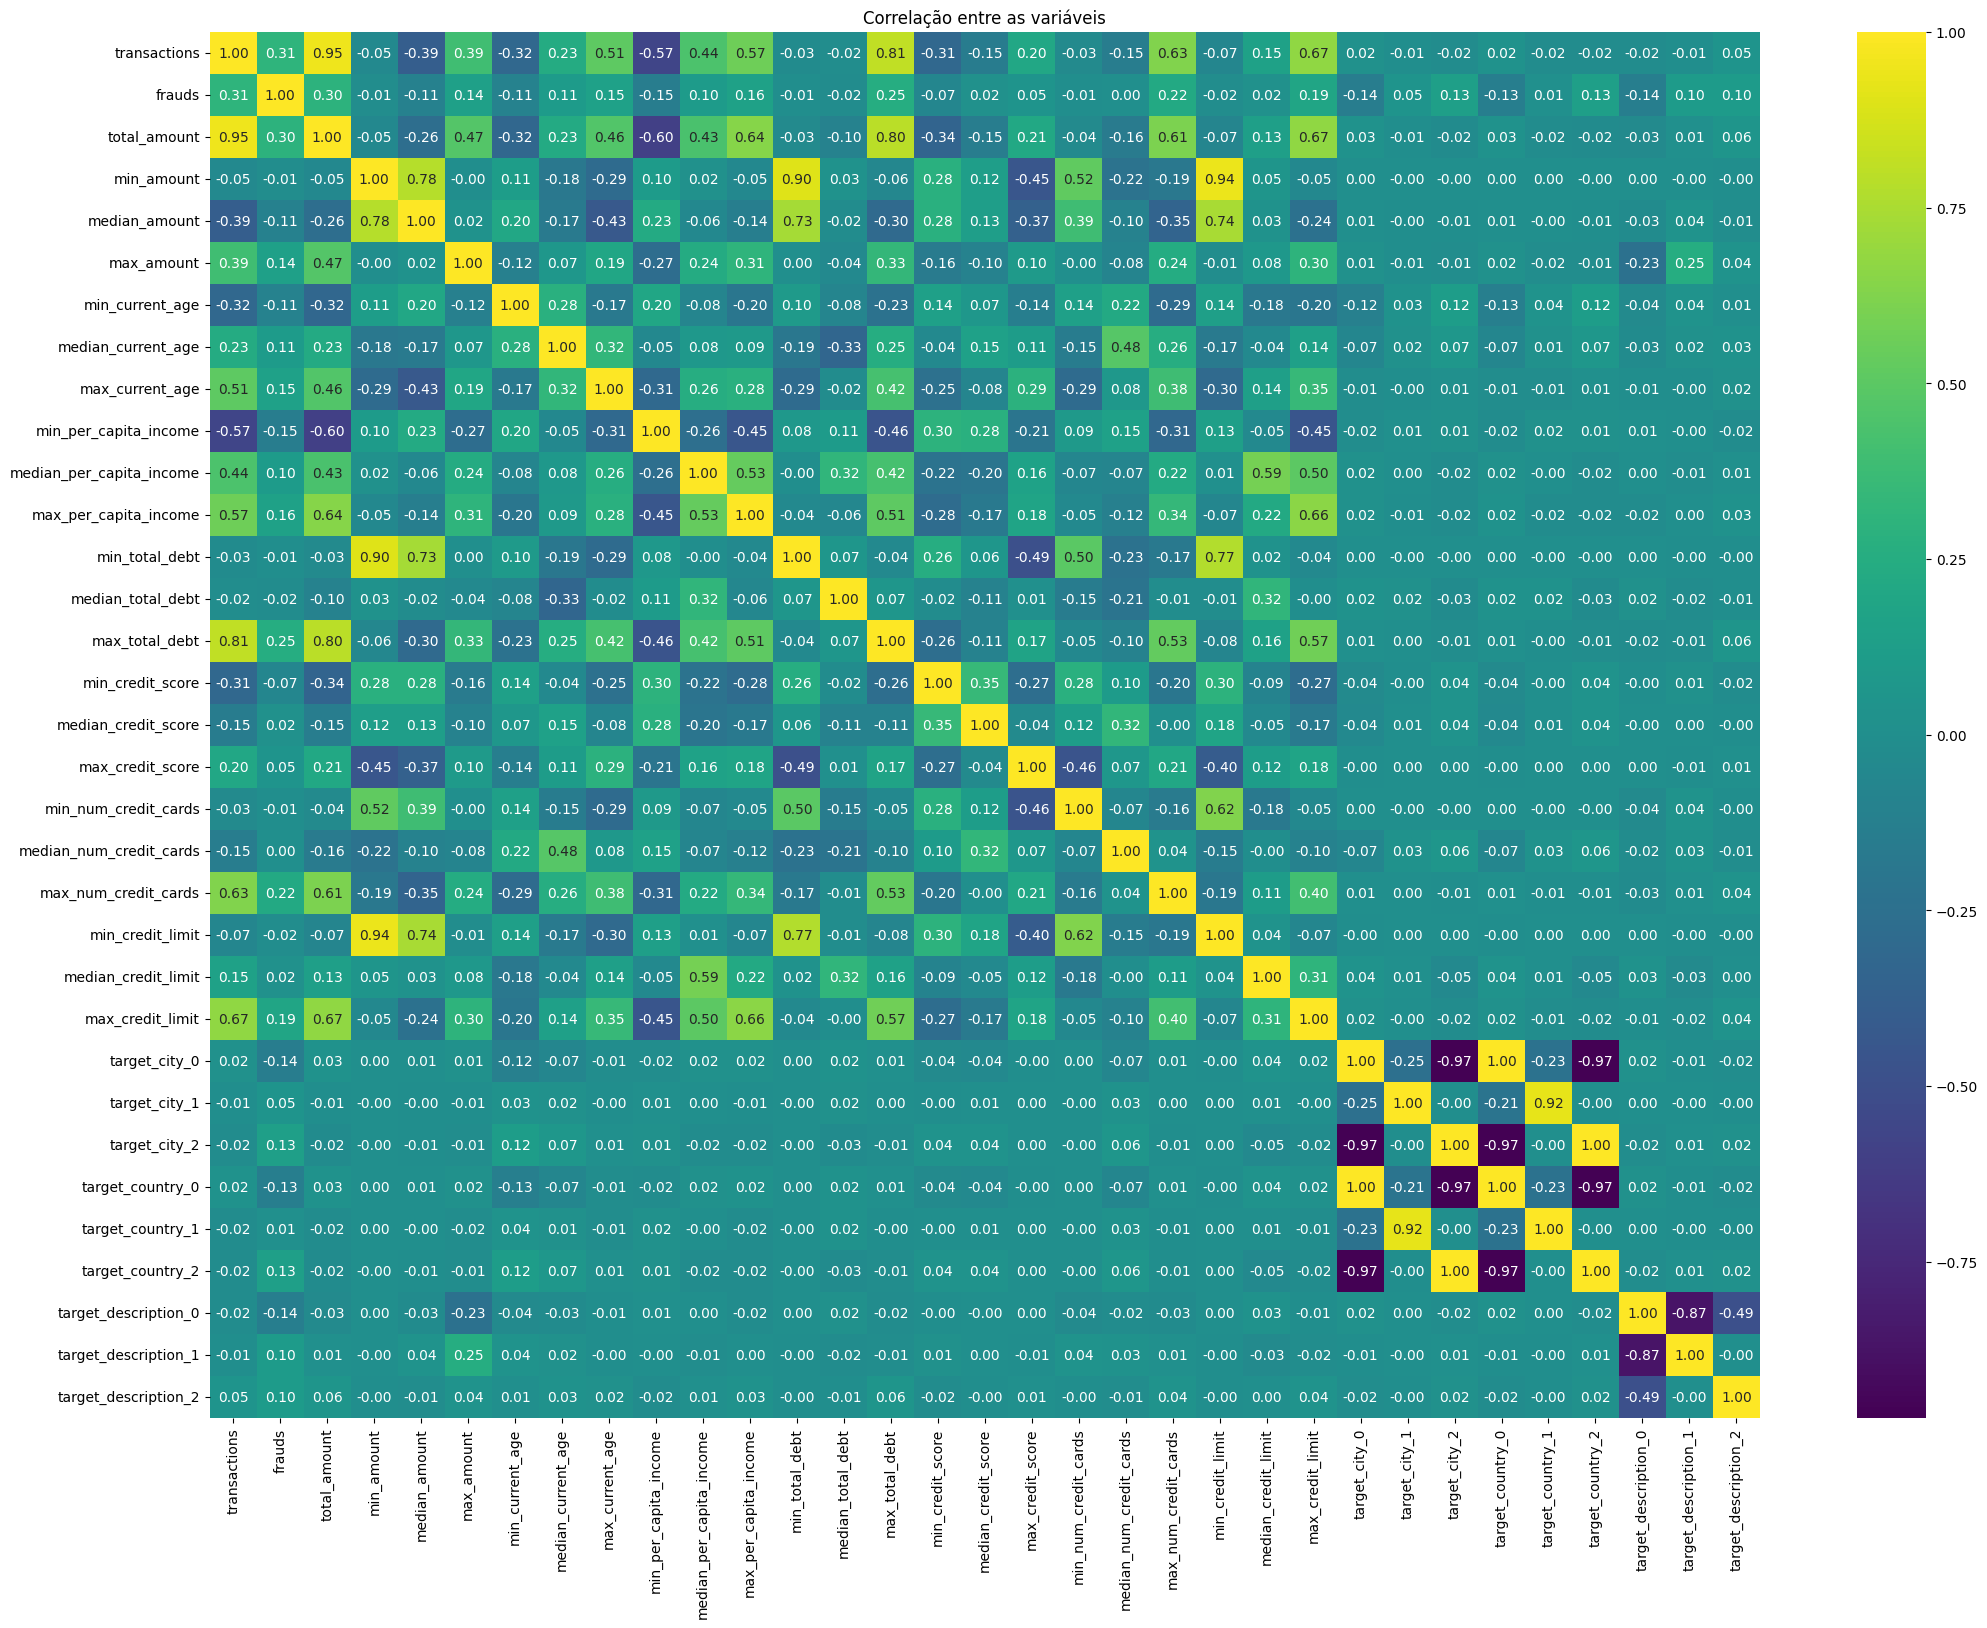

In [252]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

### Conversão de variável categorica com multiplos valores

#### Análise de proporção das categorias em relação a variavel alvo de fraude

Objetivo: Analisar se seria possível agrupar categorias com menor frequência em uma categoria Outros

In [253]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.12592
"""Miscellaneous Food Stores""",0.092598
"""Service Stations""",0.089845
"""Eating Places and Restaurants""",0.079059
"""Drug Stores and Pharmacies""",0.061069


In [254]:
df_proportion.shape

(108, 2)

In [255]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [256]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.879824,7402


In [257]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.120176,5440


#### Conversão das categorias em grupos de igual similariedade através de classificação via LLM

In [258]:
def execute_command_llm(data):
  response = azure_client.chat.completions.create(
    messages=[
         {
             "role": "user",
             "content": data
         },
    ],
    model='o1',
    max_completion_tokens=16000
  )
  return json.loads(response.choices[0].message.content.replace('```json', '').replace('```', ''))

In [259]:
prompt = """
Voce é um agente de inteligência artificial especializado em análise de grupos de negócios e com expertise nesse tipo de tarefa.

Sua tarefa será segmentar as categorias disponíveis em <categories></categories> em grupos com base em suas características de forma que esses grupos sejam homogêneos internamente e heterogêneos entre eles.
Utilize os possíveis grupos, já existentes ou não, disponíveis em <groups></groups> para reorganizar essas categorias. Caso necessite crie novos grupos.

OS grupos deverão ter o seguinte formato:
```json
[{\"cluster\":\"Health and Wellbeing\",\"items\":[\"Hospitals\",\"Medical Clinics\",\"Pharmacies\"]}]
```

Garanta que todos os categorias estejam segmentados em grupos.

<categories>
@categories
</categories>

<groups>
@groups
</groups
"""

In [260]:
def segment_categories(categories, groups):
  data = prompt.replace('@categories', str.join('\n', categories)).replace('@groups', str.join('\n', groups))
  return execute_command_llm(data)

In [261]:
unique_categories =  df['description'].unique().to_list()
len(unique_categories)

108

In [262]:
categories_cluster = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  if os.path.exists('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/categories.json'):
    shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/categories.json','/content/')
    with open('/content/categories.json', 'r') as file:
      categories_cluster = json.load(file)
      print('Categories loaded from drive')
  else:
    print('Categories not found in drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categories loaded from drive


In [263]:
if not categories_cluster:

  categories_to_cluster = unique_categories.copy()

  while len(categories_to_cluster) > 0:
    categories_cluster = segment_categories(
        str.join(';', categories_to_cluster),
        json.dumps(categories_cluster, ensure_ascii=True) if categories_cluster else "[]"
    )

    categories_from_cluster = sum(list(map(lambda x: x['items'], categories_cluster)), [])
    categories_to_cluster = [category for category in unique_categories if category not in categories_from_cluster]

    if categories_to_cluster:
      print(f'There are categories not in clusters: {str.join(", ", categories_to_cluster)}')
  else:
    print('All categories were clustered')

  with open('/content/categories.json', 'w') as file:
      json.dump(categories_cluster, file, ensure_ascii=True)

  if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    shutil.copy('/content/categories.json', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/')

In [264]:
categories_cluster = sum(list(map(lambda x: [dict(category=x['cluster'], description=item) for item in x['items']], categories_cluster)), [])
categories_cluster = pl.DataFrame(categories_cluster)
categories_cluster.head()

category,description
str,str
"""Arts, Entertainment & Recreati…","""Amusement Parks, Carnivals, Ci…"
"""Arts, Entertainment & Recreati…","""Motion Picture Theaters"""
"""Arts, Entertainment & Recreati…","""Theatrical Producers"""
"""Arts, Entertainment & Recreati…","""Betting (including Lottery Tic…"
"""Construction & Contractors""","""Heating, Plumbing, Air Conditi…"


In [265]:
df = df.join(categories_cluster, on='description', how='left')
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,card_has_chip,date_window,has_error,category
i64,datetime[ns],i64,i64,f64,str,i64,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,i64,f64,str,i64,str,str,str,str,str,datetime[ns],str,str
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,52722.0,"""5311""",null,"""Department Stores""",0,48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,1,9100.0,"""09/2005""",2015,"""No""","""No""","""Bettendorf""","""United States""","""Yes""",2010-01-01 00:00:00,"""no""","""Retail - General & Department"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,92084.0,"""4829""",null,"""Money Transfer""",0,49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,1,14802.0,"""01/2006""",2008,"""No""","""No""","""Vista""","""United States""","""Yes""",2010-01-01 00:00:00,"""no""","""Financial & Insurance"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…",0,51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,1,19113.0,"""07/2009""",2014,"""No""","""No""","""Harwood""","""United States""","""Yes""",2010-01-01 00:00:00,"""no""","""Food & Beverage"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,10464.0,"""5942""",null,"""Book Stores""",0,47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,1,89.0,"""01/2008""",2015,"""No""","""No""","""Bronx""","""United States""","""Yes""",2010-01-01 00:00:00,"""no""","""Retail - Specialty"""
7475335,2010-01-01 00:14:00,1684,2140,26.46,"""Online Transaction""",39021,null,"""4784""",null,"""Tolls and Bridge Fees""",0,56,65,1963,11,"""Male""","""27019 Madison Lane""",36.34,-83.28,13668.0,27861.0,108313.0,782,5,"""Mastercard""","""Debit (Prepaid)""",5955075527372953,"""05/2021""",513,1,46.0,"""03/2007""",2012,"""No""","""Yes""","""Online""","""Online""","""Yes""",2010-01-01 00:00:00,"""no""","""Transportation & Logistics"""


In [266]:
df.filter(df['category'].is_null())

id,date,client_id,card_id,amount,use_chip,merchant_id,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,card_has_chip,date_window,has_error,category
i64,datetime[ns],i64,i64,f64,str,i64,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,i64,f64,str,i64,str,str,str,str,str,datetime[ns],str,str


#### Aplicação da conversão das categorias agrupadas em grupos percentuais para os registros agrupados

In [267]:
# for column in ['category']:
#   df_field = convert_categorical_to_percent(df, column, 'date_window')
#   df_model = df_model.join(df_field, on='date_window', how='left')
# df_model.head(10)

### Agrupamento de informações

In [268]:
df_model = df_model.with_columns(
    pl.when(pl.col('frauds') > pl.lit(0))
      .then(pl.lit(1))
      .otherwise(pl.lit(0))
      .shift(n=1)
      .alias('previous_frauds')
      .fill_null(0)
)

### Análise de correlação do dataset completo

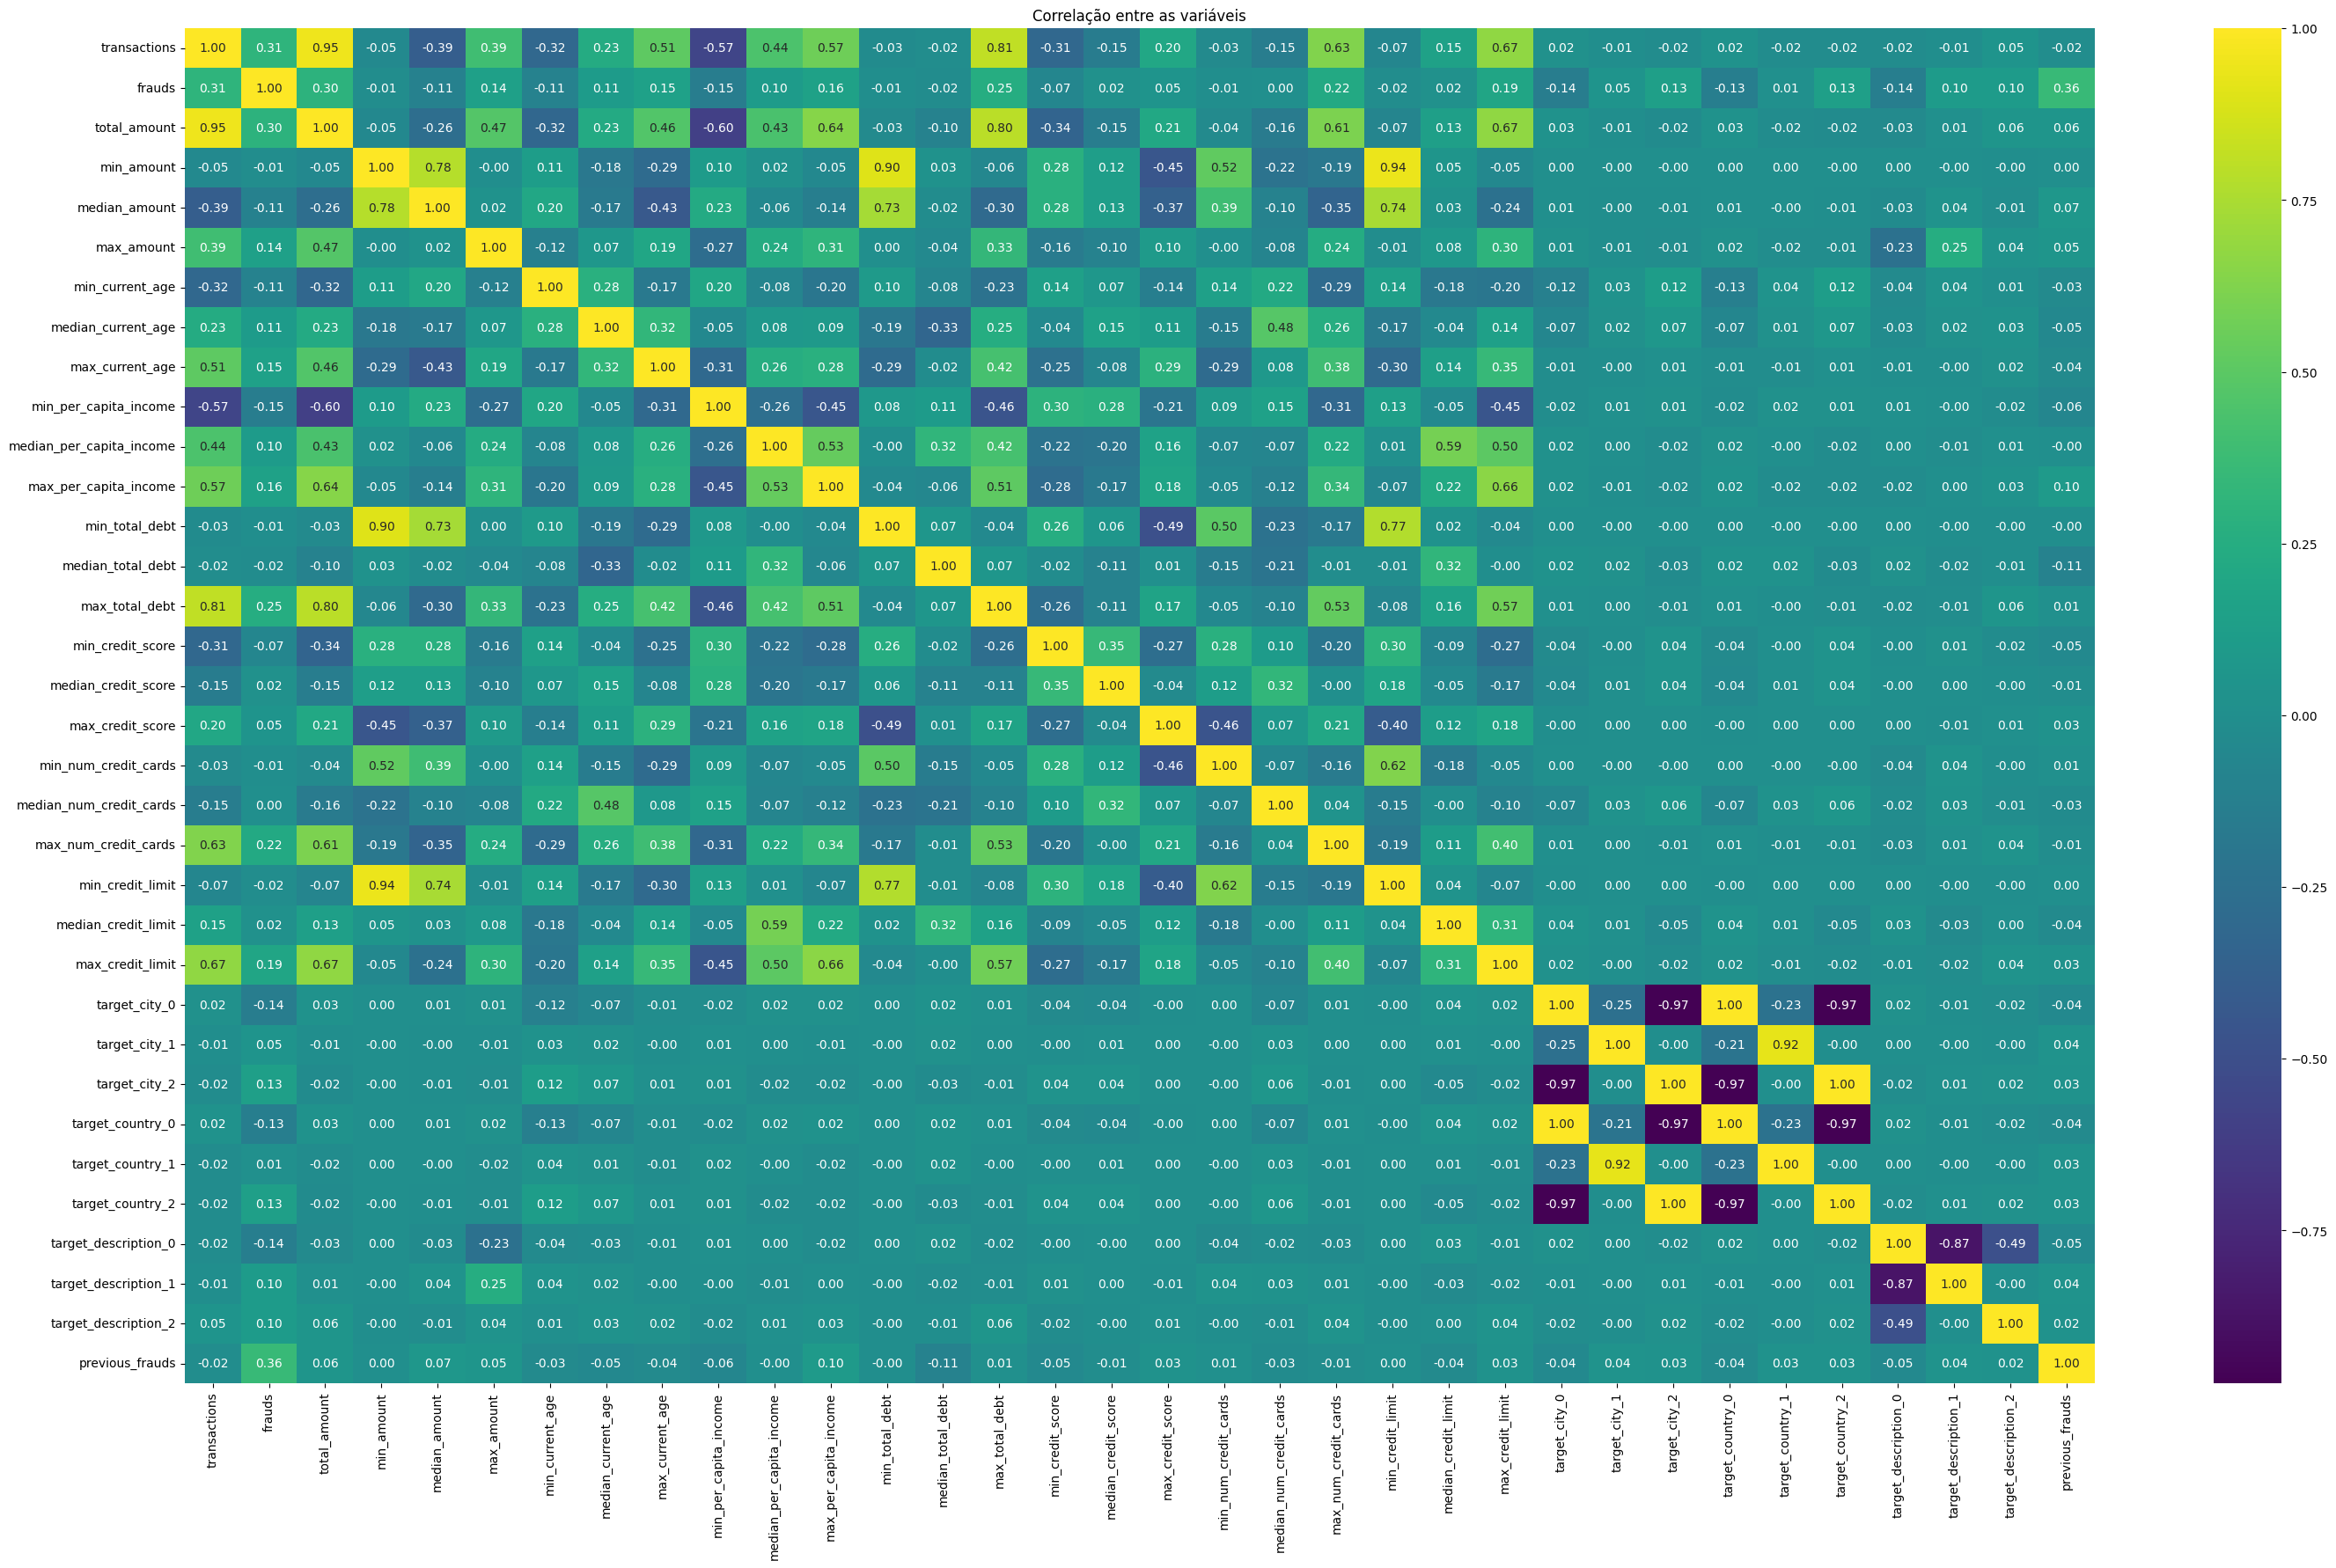

In [269]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [270]:
len(corr.columns)

34

In [271]:
def remove_highly_correlated_features(df, threshold=0.75):
    """
    Remove apenas uma variável de cada par altamente correlacionado
    Critério: manter a variável com Menor variância
    """
    corr_matrix = df.corr()
    upper_triangle = np.triu(np.abs(corr_matrix), k=1)

    high_corr_pairs = np.where(upper_triangle > threshold)
    columns_to_remove = set()

    for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]

        if col_i not in columns_to_remove and col_j not in columns_to_remove:
            var_i = df[col_i].var()
            var_j = df[col_j].var()

            if var_i < var_j:
                columns_to_remove.add(col_i)
            else:
                columns_to_remove.add(col_j)

    return list(columns_to_remove)

In [272]:
colunas_filtradas = remove_highly_correlated_features(df_model.to_pandas().drop(columns=['date_window', 'transactions']))
colunas_filtradas

['target_country_1',
 'target_description_1',
 'min_credit_limit',
 'target_country_2',
 'total_amount',
 'target_city_2',
 'min_amount',
 'target_country_0']

In [273]:
df_model = df_model.drop(colunas_filtradas)

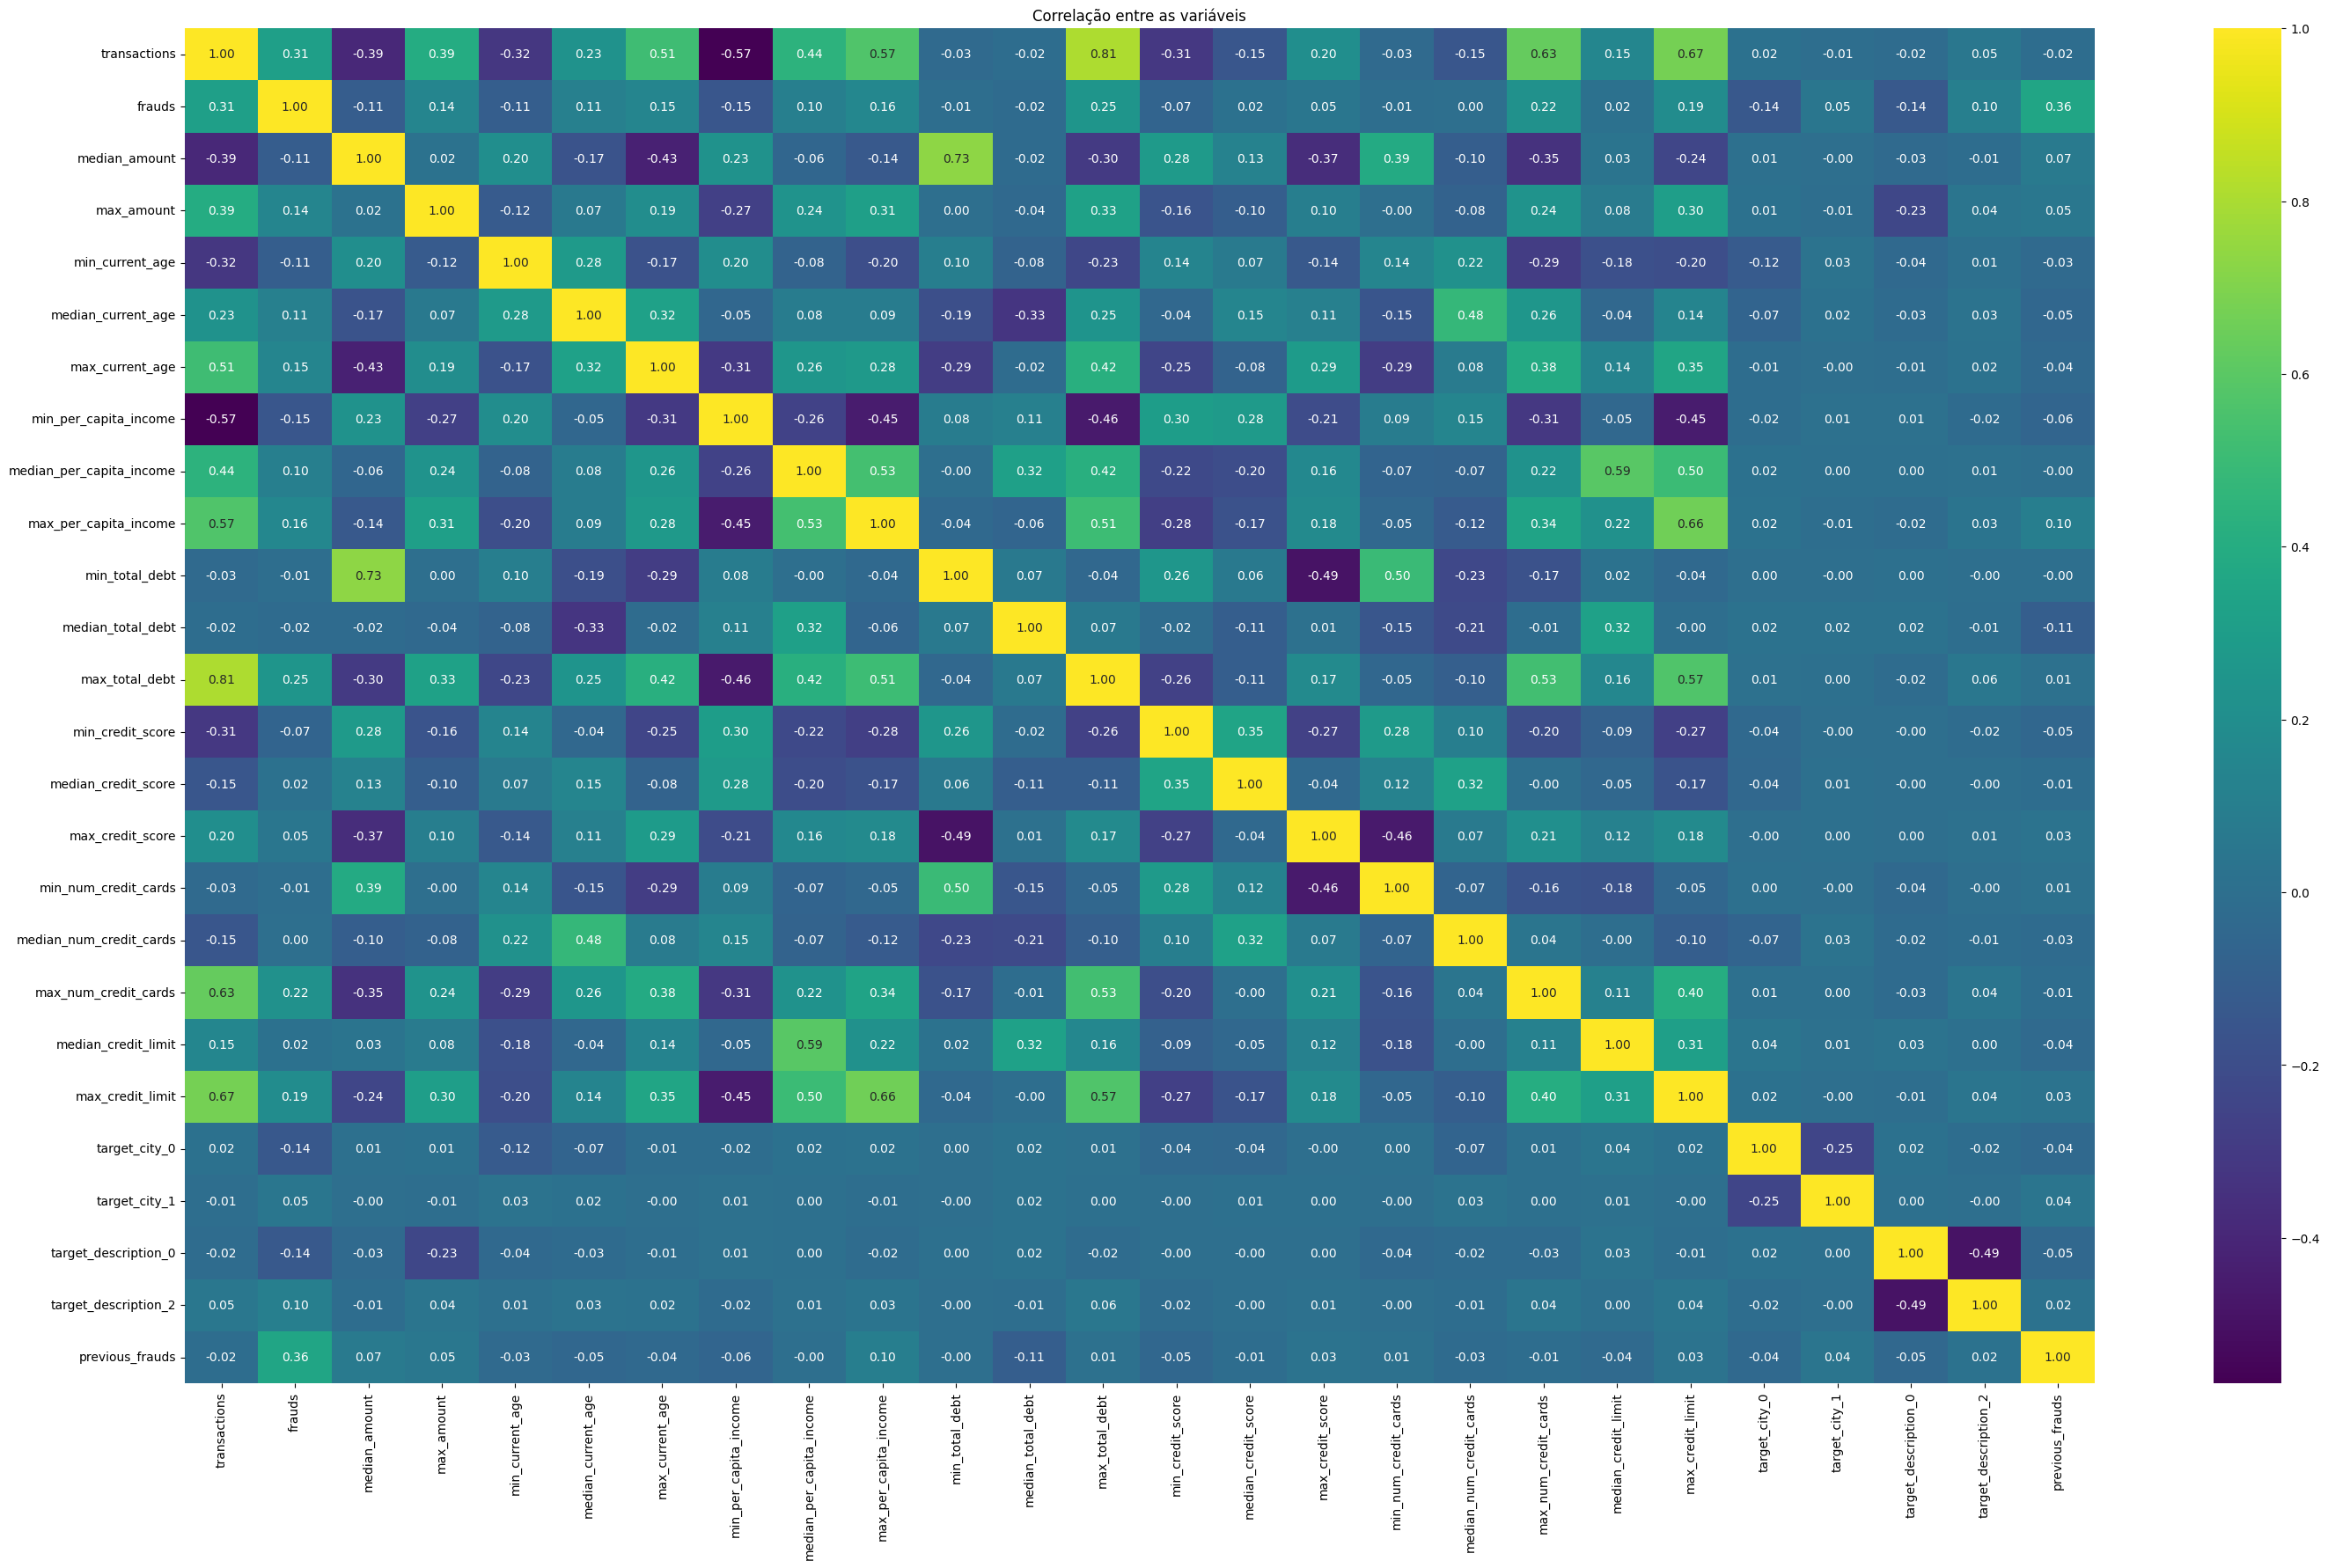

In [274]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Persistência do novo dataset

In [275]:
df_model.columns = [str(column).replace('-', '_').replace('&_', '').replace('__', '').replace('___', '').replace(',', '').replace('(', '').replace(')', '').replace('\'', '') for column in df_model.columns]

In [276]:
df_model.write_parquet('./datasets/transactions_features.parquet', use_pyarrow=True)

In [277]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  shutil.copy('./datasets/transactions_features.parquet', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [278]:
df_model.shape

(14363, 27)